In [1]:
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from mlflux.datafunc import data_split_psd
from mlflux.ann import RealFluxDataset

%load_ext autoreload
%autoreload 3

### Re-compute bulk formula prediction

In [2]:
# Use bulk algorithm 3.0 to be consistent with GOTM test
from mlflux.datafunc import load_psd
ds_psd = load_psd('../../data/PSD/fluxes_all_cruises_compilation.nc', algo='coare3p0') # This load_psd function includes applybulk
ds_psd['tauby'] = xr.zeros_like(ds_psd['taubx']) # bulk formula doesn't predict tauy
ds_psd.to_netcdf('../../data/Processed/psd_coare3p0.nc')

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/ext3/miniconda3/lib/python3.11/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


Number of samples: 10079


/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)


In [2]:
psd = xr.load_dataset('../../data/Processed/psd_coare3p0.nc')

# 77, 69, 83, 78, 87, 72, 71, 68, 67, 73
split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]]
split2 = [[77, 83, 78, 87, 72, 71, 68, 67, 73], [69], [69]]
split3 = [[77, 69, 78, 87, 72, 71, 68, 67, 73], [83], [83]]
split4 = [[77, 69, 83, 78, 68, 67, 73], [87, 72, 71], [87, 72, 71]]
split5 = [[77, 69, 83, 78, 87, 72, 71, 67, 73], [68], [68]]
split6 = [[77, 69, 83, 68, 87, 72, 71], [78, 67, 73], [78, 67, 73]]
split_ensem = [split1, split2, split3, split4, split5, split6]

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


### One net for 1 output

In [3]:
''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff 
import torch.nn as nn

class poo(nn.Module):
    def __init__(self, n_in, n_out, hidden_channels=[24, 24], degree=None, ACTIVATION='no'):  
        super().__init__()
        self.n_in = n_in
        self.n_out = n_out
        print('Artificial nn with zero prediction!')
    def forward(self, x):
        return torch.zeros((x.shape[0], self.n_out))

class Fluxdiff(FluxANNs):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = poo(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)  

In [4]:
# class RealFluxDataset(Dataset):
#     def __init__(self, ds, input_keys=['U','tsea','tair','rh'], output_keys=['taucx','taucy','hsc','hlc'], 
#                  bulk_keys=['taubx','tauby','hsb','hlb'], weightfunc=sample_weights):
        
#         ###### Assemble input and output features ######
#         self.X = torch.tensor(np.hstack([ds[key].values.reshape(-1,1) for key in input_keys]).astype('float32'))
#         self.Y = torch.tensor(np.hstack([ds[key].values.reshape(-1,1) for key in output_keys]).astype('float32'))
#         ###### Assemble bulk ######
#         self.Bulk = torch.tensor(np.hstack([ds[key].values.reshape(-1,1) for key in bulk_keys]).astype('float32'))    
#         ###### Weights according to weightfunc of choice, weight needs to match output dimension ######
#         weights = weightfunc(self.X[:,0]).reshape(-1,1)
#         weights = np.repeat(weights, len(output_keys), axis=1)
#         self.W = torch.tensor(weights.astype('float32'))
        
#     def __len__(self):
#         return self.X.shape[0]

#     def __getitem__(self, idx):
#         return self.X[idx], self.Y[idx], self.W[idx]
        
class ResidualDataset(RealFluxDataset):
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]-self.Bulk[idx], self.W[idx]
    

In [29]:
''' Momentum flux models '''
momentum_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,32,16],'ACTIVATION':'exponential'}
# para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 10, 1.0, 1.0)

for i, split in enumerate(split_ensem[0:1]):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    # ikeys = ['U','tsea','tair','rh','qair']
    okeys = ['taucx']
    bkeys = ['taubx']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}   
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([0.]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([1.]).reshape(1,-1).astype('float32'))}
    model.datasplit = split
    training_paras = {'batchsize':100, 'num_epochs':500, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':False, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data, validating_data, training_paras, VERBOSE=False)
    momentum_model_ensem.append(model)
    
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/one_output_anns/Flux41_momentum_3layers_split%g" %(i+1))
    # model.save(fname="../../saved_model/one_output_anns/Flux51_momentum_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068
Artificial nn with zero prediction!
training took 87.75 seconds, loss at last epoch -208.0418


AttributeError: 'list' object has no attribute 'detach'

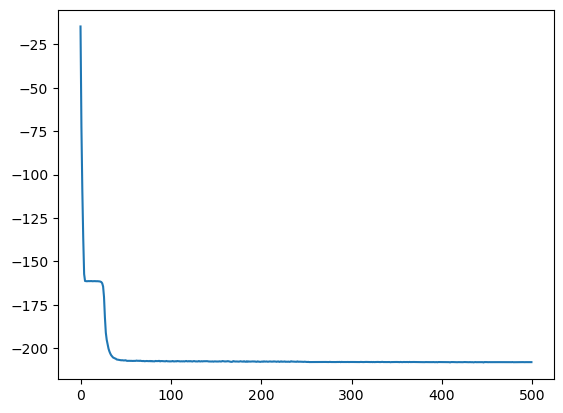

In [28]:
for model in momentum_model_ensem:
    plt.plot(model.log['LLLoss'])
    plt.plot(model.log['validating_LLLoss'].detach().numpy())

In [8]:
''' Latent heat flux models '''
latent_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}
# para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    # ikeys = ['U','tsea','tair','rh','qair']
    okeys = ['hlc']
    bkeys = ['hlb']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}   
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([0.]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([1.]).reshape(1,-1).astype('float32'))}
    model.datasplit = split
    training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data, validating_data, training_paras, VERBOSE=False)
    latent_model_ensem.append(model)
    
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/one_output_anns/Flux41_momentum_3layers_split%g" %(i+1))
    # model.save(fname="../../saved_model/one_output_anns/Flux51_momentum_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068
Artificial nn with zero prediction!


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 61 epochs.
training took 6.51 seconds, loss at last epoch 1647.4584
Training samples: 8463
Validating samples: 1610
Testing samples: 1610
Artificial nn with zero prediction!


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 61 epochs.
training took 7.92 seconds, loss at last epoch 1154.8630
Training samples: 7424
Validating samples: 2649
Testing samples: 2649
Artificial nn with zero prediction!


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 61 epochs.
training took 6.92 seconds, loss at last epoch 1028.3081
Training samples: 9194
Validating samples: 879
Testing samples: 879
Artificial nn with zero prediction!


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 61 epochs.
training took 8.49 seconds, loss at last epoch 752.6868
Training samples: 8826
Validating samples: 1247
Testing samples: 1247
Artificial nn with zero prediction!


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 61 epochs.
training took 8.19 seconds, loss at last epoch 702.0254
Training samples: 9453
Validating samples: 620
Testing samples: 620
Artificial nn with zero prediction!


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 61 epochs.
training took 8.76 seconds, loss at last epoch 740.2520


In [9]:
from scipy.stats import wasserstein_distance

def ensem_score_residual(model_ensem, keys, N=6):
    
    # Pick out the variables needed
    vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
    res_mean = []; res_var = []; di = []   
    
    # sample from standard Gaussian for distance
    s = np.random.normal(0, 1, len(vd.X)) 
    
    for i in range(0,N):
        model = model_ensem[i]
        error = vd.Y.detach().numpy() - vd.Bulk.detach().numpy()
        error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5
        res_mean.append(error_norm.mean())
        res_var.append(error_norm.std())
        di.append(wasserstein_distance(error_norm.squeeze(), s))
        print(np.mean(error**2),np.std(error)**2,np.mean(model.pred_var(vd.X).detach().numpy()))

    return res_mean, res_var, di

0.0022284046 0.002189999293632519 0.018686183
0.0022284046 0.002189999293632519 0.019333277
0.0022284046 0.002189999293632519 0.018510427
0.0022284046 0.002189999293632519 0.018885566
0.0022284046 0.002189999293632519 0.018903416
0.0022284046 0.002189999293632519 0.01929803


Text(0.5, 0, 'Model number')

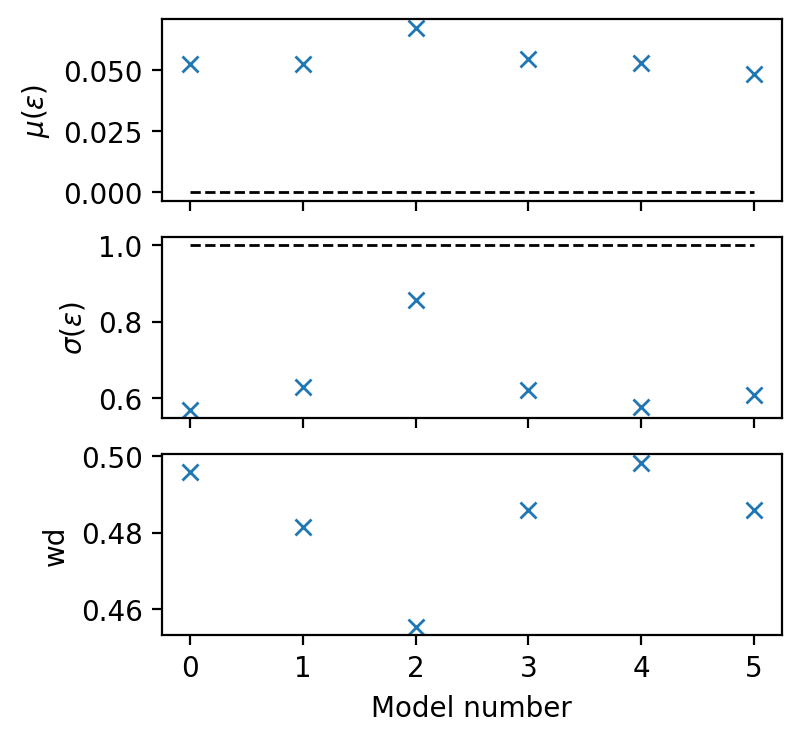

In [15]:
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
res_mean, res_var, di = ensem_score_residual(momentum_model_ensem, keys, N=6)

# keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
# res_mean, res_var, di = ensem_score_residual(latent_model_ensem, keys, N=6)

fig, axes = plt.subplots(3, 1, sharex=True, figsize=[4,4], dpi=200)
axes[0].plot(res_mean, 'x')
# axes[0].set_ylim([-0.1,0.2])
axes[0].hlines(y=0., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[1].plot(res_var, 'x')
# axes[1].set_ylim([0,4])
axes[1].hlines(y=1., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[2].plot(di, 'x')
# axes[2].set_ylim([0,1.5])

axes[0].set_ylabel('$\mu(\epsilon)$')
axes[1].set_ylabel('$\sigma(\epsilon)$')
axes[2].set_ylabel('wd')
plt.xlabel('Model number')

#### Plot residuals

(-0.8, 0.8)

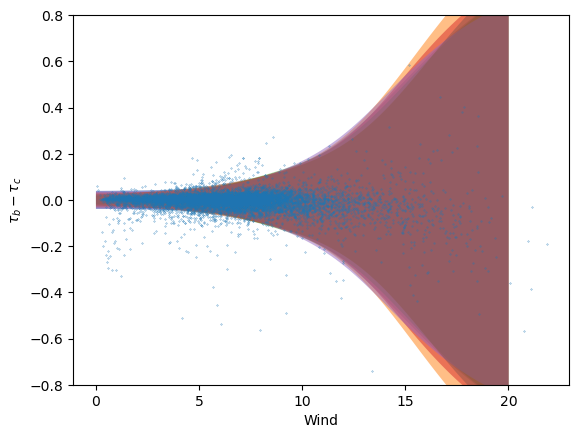

In [16]:
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)

plt.plot(vd.X[:,0], vd.Bulk-vd.Y, '.', markersize=0.5)

U = np.linspace(0,20,101).reshape(-1,1)
Ta = np.ones([101,1]) * 20
To = np.ones([101,1]) * 20
RH = np.ones([101,1]) * 80
X = np.hstack([U,Ta,To,RH]).astype('float32')

# model = momentum_model_ensem[2]
for model in momentum_model_ensem:
    std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
    plt.fill_between(x=X[:,0], y1=std_pred.flatten(), y2=-std_pred.flatten(),alpha=0.5)

plt.xlabel('Wind'); plt.ylabel(r'$\tau_b - \tau_c$ ')
plt.ylim([-0.8,0.8])

In [32]:
vd.X[:,0].detach().numpy().shape

(10079,)

In [34]:
std_pred.flatten().shape

(10079,)

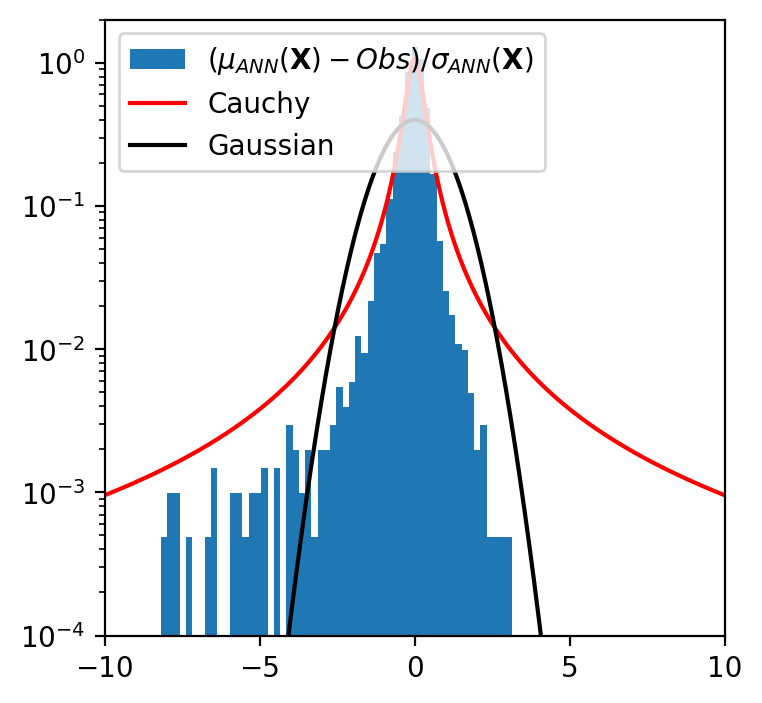

In [52]:
vd = ResidualDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)

i = 0
model = momentum_model_ensem[i]
    
error = vd.Bulk.detach().numpy() - vd.Y.detach().numpy()
error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5

fig = plt.figure(figsize=(4,4),dpi=200)
plt.hist(error_norm, bins=np.linspace(-10, 10, 100), density=True, 
         label='$(\mu_{ANN}(\mathbf{X}) - Obs)/\sigma_{ANN}(\mathbf{X})$')

mu = 0      # mean
sigma = 1   # standard deviation

x = np.linspace(mu - 10*sigma, mu + 10*sigma, 1000)
y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)
y_ = 1/((np.pi*0.3)*(1+(x/0.3)**2))

plt.plot(x, y_, color='r', label='Cauchy')
plt.plot(x, y, color='k', label='Gaussian')
plt.legend(loc='upper left')
plt.xlim([-10,10]); plt.ylim([0.0001,2])
plt.yscale('log')

### One net but without assumption that bulk is un-biased

In [53]:
''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff 
import torch.nn as nn

class poo(nn.Module):
    def __init__(self, n_in, n_out, hidden_channels=[24, 24], degree=None, ACTIVATION='no'):  
        super().__init__()
        self.n_in = n_in
        self.n_out = n_out
        print('Artificial nn with zero prediction!')
    def forward(self, x):
        return torch.zeros((x.shape[0], self.n_out))

class Fluxdiff(FluxANNs):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)  

In [54]:
''' Momentum flux models '''
momentum_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}
# para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    # ikeys = ['U','tsea','tair','rh','qair']
    okeys = ['taucx']
    bkeys = ['taubx']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}   
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([0.]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([0.05]).reshape(1,-1).astype('float32'))}
    model.datasplit = split
    training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data, validating_data, training_paras, VERBOSE=False)
    momentum_model_ensem.append(model)
    
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/one_output_anns/Flux41_momentum_3layers_split%g" %(i+1))
    # model.save(fname="../../saved_model/one_output_anns/Flux51_momentum_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 354 epochs.
training took 67.27 seconds, loss at last epoch 18.5284
Training samples: 8463
Validating samples: 1610
Testing samples: 1610


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 130 epochs.
training took 29.33 seconds, loss at last epoch 15.0894
Training samples: 7424
Validating samples: 2649
Testing samples: 2649


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 101 epochs.
training took 20.05 seconds, loss at last epoch 11.0245
Training samples: 9194
Validating samples: 879
Testing samples: 879


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 426 epochs.
training took 104.02 seconds, loss at last epoch 9.6386
Training samples: 8826
Validating samples: 1247
Testing samples: 1247


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 135 epochs.
training took 31.81 seconds, loss at last epoch 28.2969
Training samples: 9453
Validating samples: 620
Testing samples: 620


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 180 epochs.
training took 45.26 seconds, loss at last epoch 13.0900


In [57]:
def ensem_score(model_ensem, keys, N=6):
    
    # Pick out the variables needed
    vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
    res_mean = []; res_var = []; di = []   
    
    # sample from standard Gaussian for distance
    s = np.random.normal(0, 1, len(vd.X)) 

    for i in range(0,N):
        model = model_ensem[i]       
        error = model.pred_mean(vd.X).detach().numpy() - vd.Y.detach().numpy()
        error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5
        res_mean.append(error_norm.mean())
        res_var.append(error_norm.std())
        di.append(wasserstein_distance(error_norm.squeeze(), s))

    return res_mean, res_var, di

Text(0.5, 0, 'Model number')

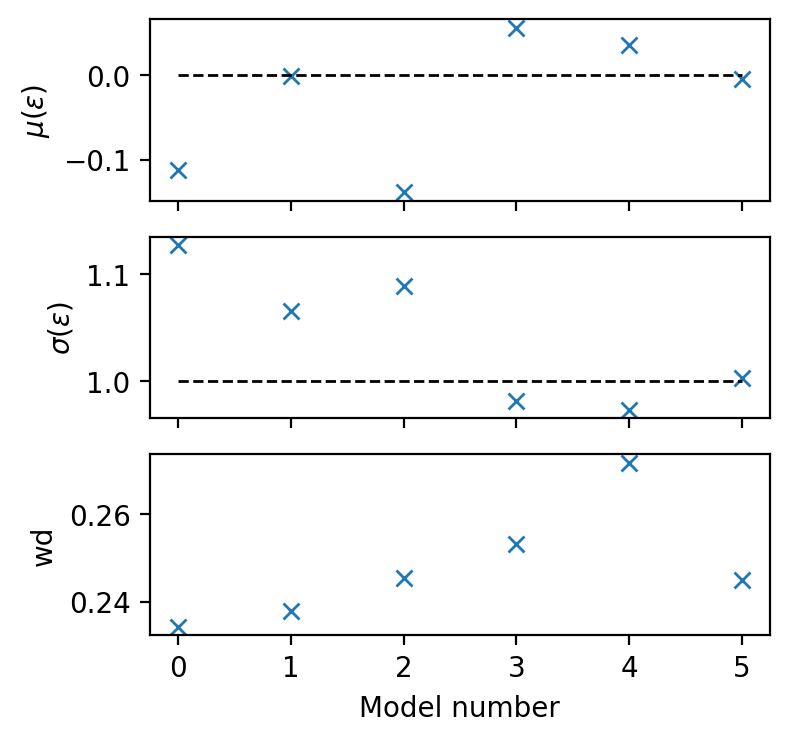

In [58]:
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
res_mean, res_var, di = ensem_score(momentum_model_ensem, keys, N=6)

fig, axes = plt.subplots(3, 1, sharex=True, figsize=[4,4], dpi=200)
axes[0].plot(res_mean, 'x')
# axes[0].set_ylim([-0.1,0.2])
axes[0].hlines(y=0., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[1].plot(res_var, 'x')
# axes[1].set_ylim([0,4])
axes[1].hlines(y=1., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[2].plot(di, 'x')
# axes[2].set_ylim([0,1.5])

axes[0].set_ylabel('$\mu(\epsilon)$')
axes[1].set_ylabel('$\sigma(\epsilon)$')
axes[2].set_ylabel('wd')
plt.xlabel('Model number')

(0.0, 0.6)

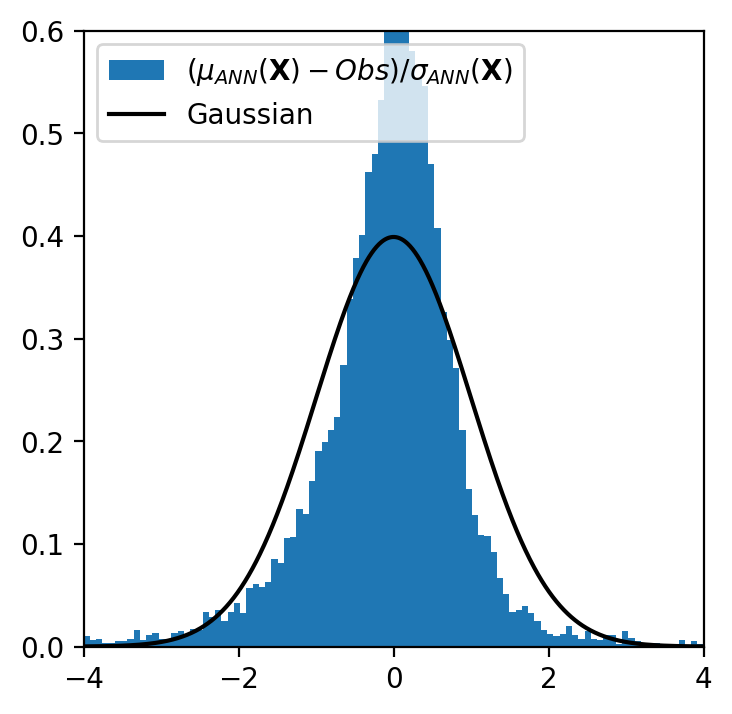

In [66]:
vd = ResidualDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)

i = 1
model = momentum_model_ensem[i]
    
error = vd.Bulk.detach().numpy() - vd.Y.detach().numpy()
error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5

fig = plt.figure(figsize=(4,4),dpi=200)
plt.hist(error_norm, bins=np.linspace(-4, 4, 100), density=True, 
         label='$(\mu_{ANN}(\mathbf{X}) - Obs)/\sigma_{ANN}(\mathbf{X})$')

mu = 0      # mean
sigma = 1   # standard deviation

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)
y_ = 1/((np.pi*0.3)*(1+(x/0.3)**2))

# plt.plot(x, y_, color='r', label='Cauchy')
plt.plot(x, y, color='k', label='Gaussian')
plt.legend(loc='upper left')
plt.xlim([-4,4]) 
plt.ylim([0,0.6])
# plt.yscale('log')

In [91]:
U = np.linspace(0,20,101).reshape(-1,1)
Ta = np.ones([101,1]) * 20
To = np.ones([101,1]) * 20
RH = np.ones([101,1]) * 100
X = np.hstack([U,Ta,To,RH])
Delta = model.pred_mean(torch.tensor(X.astype('float32'))).detach().numpy()

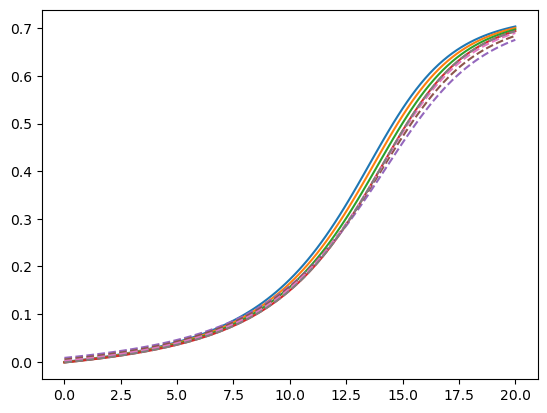

In [96]:
U = np.linspace(0,20,101).reshape(-1,1)
Ta = np.ones([101,1]) * 20
To = np.ones([101,1]) * 20

for rh in (60,70,80,90):
    RH = np.ones([101,1]) * rh
    X = np.hstack([U,Ta,To,RH])
    Delta = model.pred_mean(torch.tensor(X.astype('float32'))).detach().numpy()
    plt.plot(U.flatten(), Delta.flatten())

RH = np.ones([101,1]) * rh
Ta = np.ones([101,1]) * 20


for to in (5,10,15,20):
    To = np.ones([101,1]) * to
    X = np.hstack([U,Ta,To,RH])
    Delta = model.pred_mean(torch.tensor(X.astype('float32'))).detach().numpy()
    plt.plot(U.flatten(), Delta.flatten(), '--')

In [ ]:
''' Predictor with four inputs and four outputs '''
class Flux44(FluxANNs):
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2 (or scale)
        scale = torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([1,1,1,1]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
    
    def evaluate_uniform(self):
        pass

''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff   
class Flux44diff(Flux44):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)     

In [ ]:
###### Network hyperparameter ######
para1 = {'n_in':5,'n_out':4,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':5,'n_out':4,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 10.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh', 'qair']
    okeys = ['taucx', 'taucy', 'hsc', 'hlc']
    bkeys = ['taubx', 'tauby', 'hsb', 'hlb']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    ###### Run the model 5 times ######
    for run in range(5):   
        model = Flux54diff({'mean_ann_para':para1, 'var_ann_para':para2})
        model.datasplit = split
        # training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2}
        training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
        log = model.fit(training_data, validating_data, training_paras, VERBOSE=True)
        # Later we can pick one before saving but since files are pretty small they are ok 
        model.save(fname="../../saved_model/full_anns/flux54_diff_3layers_split%g_run%g" %(i+1,run))